# Time Series Style Transfer

In [1]:
import pandas as pd
import numpy as np

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TF_USE_LEGACY_KERAS"]="1"
import tensorflow as tf
import matplotlib.pyplot as plt
from configs.SimulatedData import Proposed

from datetime import datetime
import os
from utils.metric import signature_on_batch, signature_metric
from utils.DataManagement import  pd_to_tf_dset
# from utils.MLFlow_utils import save_configuration
# from utils.visualization_helpers import plot_generated_sequence2
from models.mts_style_transfer import make_generator, make_content_encoder, make_style_encoder, make_global_discriminator, create_local_discriminator
from utils.simple_metric import simple_metric_on_noise
from utils.tensorboard_log import fig_to_buff

gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs.
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized.
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
config = Proposed()
date_str = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

CONTENT_DATASET_PATH = "data/simulated_dataset/01 - Source Domain.h5"
STYLE_DATASET_PATHS = ["data/simulated_dataset/causal_shift/0.20.h5", "data/simulated_dataset/causal_shift/0.70.h5"]

EXPERIMENT_NAME = f"{date_str} - "
SAVE_FOLDER = f"experiments_logs/{EXPERIMENT_NAME}"

SEQUENCE_LENGTH = config.sequence_lenght_in_sample
GRANUARITY = config.granularity
OVERLAP = config.overlap
BS = 20 # config.batch_size
VALID_BATCH_SIZE = 50
EPOCHS = config.epochs
NUM_SEQUENCE_TO_GENERATE = config.met_params.sequence_to_generate
N_SIGNAL= 7
N_CLASSES = 2

STYLE_VECTOR_SIZE = 16
FEAT_WIENER = 2
N_SAMPLE_WIENER = SEQUENCE_LENGTH//4
NOISE_DIM= (N_SAMPLE_WIENER, FEAT_WIENER)
N_VALIDATION_SEQUENCE = 500
DISCR_STEP = 5
DISCR_THREASOLD = 0.9

### Generator loss parameters.
L_RECONSTR= 0.1
L_LOCAL = 0.1
L_GLOBAL = 0.1
L_STYLE_PRESERVATION = 0.45

### Content encoder loss
L_CONTENT= 0.1

### Style Encoder
L_DIS= 0.5
TRIPLET_R = 0.5 # Minimum distance between two points from negative pairs.
L_TRIPLET= 0.5

BASE_DIR = f"test2/{EXPERIMENT_NAME} - Style Transfer time shift"
TRAIN_LOGS_DIR_PATH = f"{BASE_DIR}/train"
VALID_LOGS_DIR_PATH = f"{BASE_DIR}/valid"
GENERATION_LOG = f"{BASE_DIR}/Generations"
os.makedirs(GENERATION_LOG)
os.makedirs(SAVE_FOLDER)

In [3]:
# server_ip = "192.168.210.102"
# mlflow_port_number= "5001"

# mlflow.set_tracking_uri(f'http://{server_ip}:{mlflow_port_number}') 
# exp = mlflow.get_experiment_by_name("Style Transfer Algorithm")

# run = mlflow.start_run(run_name=date_str) 
# mlflow.tensorflow.autolog()

In [4]:
# data_to_save= {
#         "content_dataset":CONTENT_DATASET_PATH,
#         "style_datasets":STYLE_DATASET_PATHS,
#         "SEQUENCE_LENGTH":SEQUENCE_LENGTH,
#         "granularity":GRANUARITY,
#         "overlap":OVERLAP,
#         "epochs":EPOCHS,
#         "batch_size":BS,
#         "style_vector_size":STYLE_VECTOR_SIZE,
#         "feat_wiener":FEAT_WIENER,
#         "n_sample_wiener":N_SAMPLE_WIENER,
#         "triplet_r":TRIPLET_R,
#         "n_validation_sequence":N_VALIDATION_SEQUENCE,
#         "l_style":L_STYLE_GENERATION,
#         "l_content":L_CONTENT,
#         "l_triplet":L_TRIPLET,
#         "l_realness":L_REALNESS,
#         "l_adv":L_ADV,
#         "l_reconstr":L_RECONSTR,    
#         "log_dir":BASE_DIR
#     }

# save_configuration(f"{SAVE_FOLDER}/parameters.json", data_to_save)

# Load the Datasets

In [5]:
def load_dataframe(df_path:str, drop_labels=True):
    _df= pd.read_hdf(df_path).astype(np.float32)

    if drop_labels == True:
        _df = _df.drop(columns=['labels'])

    return _df


def train_valid_split(df:pd.DataFrame):
    train_size = 0.8
    train_last_sample = int(df.shape[0]* train_size)
    _df = df.copy()

    train_df = _df.iloc[:train_last_sample]
    valid_df = _df.iloc[train_last_sample:]

    return train_df, valid_df


def pd2tf(df:pd.DataFrame, sequence_lenght, granularity, overlap, batch_size, shuffle:bool):
    total_seq_len = int(sequence_lenght* granularity)
    shift_between_sequences = int(total_seq_len* overlap)

    dset = tf.data.Dataset.from_tensor_slices(df.values)
    dset = dset.window(sequence_lenght , shift=shift_between_sequences, stride=granularity).flat_map(lambda x: x.batch(sequence_lenght, drop_remainder=True))

    if shuffle == True:
        dset = dset.shuffle(2000)

    dset = dset.batch(batch_size, drop_remainder=True)

    return dset

def loading_wrapper(df_path:str, sequence_lenght:int, granularity:int, overlap:int, batch_size:int, shuffle:bool=True, drop_labels:bool=True):
    _df = load_dataframe(df_path, drop_labels)

    _df_train, _df_valid = train_valid_split(_df)

    _dset_train = pd2tf(_df_train, sequence_lenght, granularity, overlap, batch_size, shuffle)
    _dset_valid = pd2tf(_df_valid, sequence_lenght, granularity, overlap, batch_size, shuffle)

    return _dset_train, _dset_valid


In [6]:
content_dset_train, content_dset_valid = loading_wrapper(CONTENT_DATASET_PATH, SEQUENCE_LENGTH, GRANUARITY, OVERLAP, 2*BS) # Time two for the training function.
style1_dset_train, style1_dset_valid = loading_wrapper(STYLE_DATASET_PATHS[0], SEQUENCE_LENGTH, GRANUARITY, OVERLAP, BS)
style2_dset_train, style2_dset_valid = loading_wrapper(STYLE_DATASET_PATHS[1], SEQUENCE_LENGTH, GRANUARITY, OVERLAP, BS)

In [7]:
# content_dset_train, content_dset_valid = pd_to_tf_dset(CONTENT_DATASET_PATH, BS*2, VALID_BATCH_SIZE*2)
# style1_dset_train, style1_dset_valid = pd_to_tf_dset(STYLE_DATASET_PATHS[0], BS, VALID_BATCH_SIZE)
# style2_dset_train, style2_dset_valid = pd_to_tf_dset(STYLE_DATASET_PATHS[1], BS, VALID_BATCH_SIZE)

## Get Architectures.

In [8]:
content_encoder = make_content_encoder(SEQUENCE_LENGTH, N_SIGNAL, FEAT_WIENER)
style_encoder = make_style_encoder(SEQUENCE_LENGTH, N_SIGNAL, STYLE_VECTOR_SIZE)
decoder = make_generator(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR_SIZE ,N_SIGNAL)
global_discriminator = make_global_discriminator(SEQUENCE_LENGTH, N_SIGNAL, N_CLASSES)
local_discriminator = create_local_discriminator(N_SIGNAL, SEQUENCE_LENGTH, N_CLASSES)

/home/henrihoyez/anaconda3/envs/tf/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


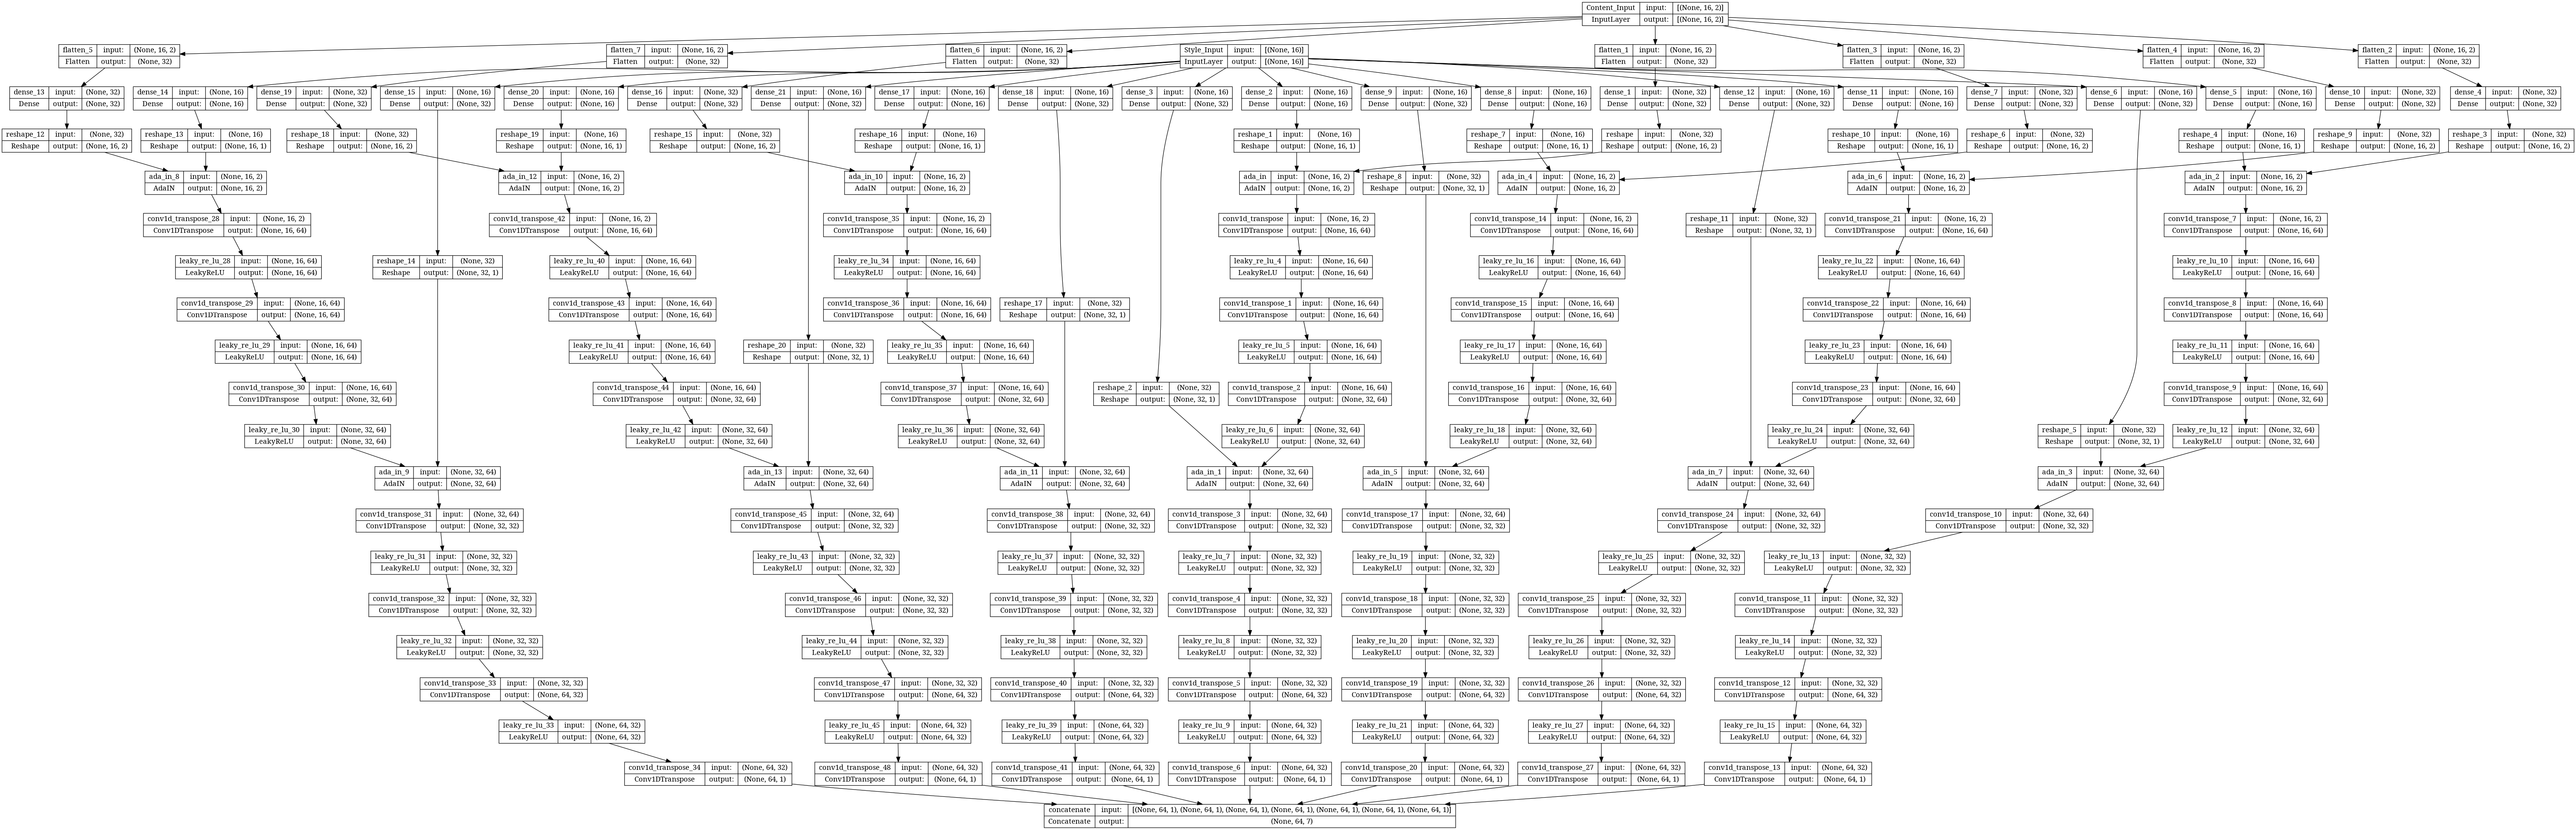

In [10]:
tf.keras.utils.plot_model(decoder, show_shapes=True)
# decoder.summary()

In [176]:
def generate(content_batch, style_batch):
    content = content_encoder(content_batch, training=False)
    style = style_encoder(style_batch, training=False)
    generated = decoder([content, style], training=False)
    return generated

In [177]:
def get_batches(dset, n_batches):
    _arr = np.array([c for c in dset.take(n_batches)])
    return _arr.reshape((-1, _arr.shape[-2], _arr.shape[-1]))

In [178]:
valid_seed_content = next(iter(content_dset_valid))
valid_seed_style = next(iter(style1_dset_valid))

train_seed_content = next(iter(content_dset_train))
train_seed_style = next(iter(style1_dset_train))

generated_sequence = generate(valid_seed_content[:int(BS)], valid_seed_style)

In [179]:
seed_content_train = get_batches(content_dset_train, 25)
seed_content_valid = get_batches(content_dset_valid, 25)

seed_style1_train = get_batches(style1_dset_train, 50)
seed_style1_valid = get_batches(style1_dset_valid, 50)

seed_style2_train = get_batches(style2_dset_train, 50)
seed_style2_valid = get_batches(style2_dset_valid, 50)

In [180]:
seed_content_trends_train, _ = simple_metric_on_noise(seed_content_train)
seed_content_trends_valid, _ = simple_metric_on_noise(seed_content_valid)

_, seed_style1_noise_train = simple_metric_on_noise(seed_style1_train)
_, seed_style1_noise_valid = simple_metric_on_noise(seed_style1_valid)

_, seed_style2_noise_train = simple_metric_on_noise(seed_style2_train)
_, seed_style2_noise_valid = simple_metric_on_noise(seed_style2_valid)

generated_style1_train = generate(seed_content_train, seed_style1_train)
generated_style2_train = generate(seed_content_train, seed_style2_train)

generated_style1_valid = generate(seed_content_valid, seed_style1_valid)
generated_style2_valid = generate(seed_content_valid, seed_style2_valid)

extracted_trends_s1_train, generated_s1_noise_train = simple_metric_on_noise(generated_style1_train)
extracted_trends_s2_train, generated_s2_noise_train = simple_metric_on_noise(generated_style2_train)

extracted_trends_s1_valid, generated_s1_noise_valid = simple_metric_on_noise(generated_style1_valid)
extracted_trends_s2_valid, generated_s2_noise_valid = simple_metric_on_noise(generated_style2_valid)

In [181]:
from sklearn.decomposition import PCA

def plot_generated_sequence2(
        content_encoder, style_encoder, decoder, 
        content_sequences, 
        style1_sequences, 
        style2_sequences, 
        real_noise_s1_train, 
        real_noise_s1_valid, 
        real_noise_s2_train, 
        real_noise_s2_valid, 
        gen_noise_s1_train, 
        gen_noise_s1_valid, 
        gen_noise_s2_train, 
        gen_noise_s2_valid, 
        show=False):

    # Make Generated sequence for visualization.
    content_of_content = content_encoder(content_sequences, training=False)
    style_of_style1= style_encoder(style1_sequences, training=False)
    style1_generated = decoder([content_of_content, style_of_style1], training=False)

    style_of_style2 = style_encoder(style2_sequences, training=False)
    style2_generated = decoder([content_of_content, style_of_style2], training=False)

    c_style1_generated = content_encoder(style1_generated, training=False)
    s_style1_generated = style_encoder(style1_generated, training=False)

    c_style2_generated = content_encoder(style2_generated, training=False)
    s_style2_generated = style_encoder(style2_generated, training=False)

    style1_signature = signature_on_batch(style1_sequences, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    style2_signature = signature_on_batch(style2_sequences, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    gen_s1_signature = signature_on_batch(style1_generated, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    gen_s2_signature = signature_on_batch(style2_generated, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)

    x = np.arange(style1_signature.shape[1]) - style1_signature.shape[1]/2

    averaged_rs1_sig = np.mean(style1_signature, axis=0)
    averaged_rs2_sig = np.mean(style2_signature, axis=0)
    averaged_gs1_sig = np.mean(gen_s1_signature, axis=0)
    averaged_gs2_sig = np.mean(gen_s2_signature, axis=0)

    # Reduce the Style Vector for visualization purposes.
    pca = PCA(2)
    style_vectors = np.vstack(
        [   style_of_style1, 
            style_of_style2, 
            s_style1_generated, 
            s_style2_generated
        ])

    pca.fit(style_vectors)

    reduced_style1 = pca.transform(style_of_style1)
    reduced_style2 = pca.transform(style_of_style2)
    reduced_style1_generated = pca.transform(s_style1_generated)
    reduced_style2_generated = pca.transform(s_style2_generated)


    all_values = np.array([content_sequences, style1_sequences, style2_sequences])
    _min, _max = np.min(all_values)-1, np.max(all_values)+ 1

    fig= plt.figure(figsize=(18, 8))
    spec= fig.add_gridspec(3, 8)

    ax00 = fig.add_subplot(spec[0:2, :2])
    ax00.set_title('Content Sequence. ($C_0$)')
    ax00.plot(content_sequences[0])
    ax00.set_ylim(_min, _max)
    ax00.grid(True)
    ax00.legend()

# #######
    ax01 = fig.add_subplot(spec[0, 2:4])
    ax01.set_title('Style Sequence 1. ($S_0$)')
    ax01.plot(style1_sequences[0])
    ax01.set_ylim(_min, _max)
    ax01.grid(True)

    ax11 = fig.add_subplot(spec[1, 2:4])
    ax11.set_title("Style Sequence 2. ($S_1$)")
    ax11.plot(style2_sequences[0])
    ax11.set_ylim(_min, _max)
    ax11.grid(True)

# #######
    ax02 = fig.add_subplot(spec[0, 4:6])
    ax02.set_title('Generated Sequence. ($C_0; S_0$)')
    ax02.plot(style1_generated[0])
    ax02.set_ylim(_min, _max)
    ax02.grid(True) 

    ax12 = fig.add_subplot(spec[1, 4:6])
    ax12.set_title('Generated Sequence. ($C_0; S_1$)')
    ax12.plot(style2_generated[1])
    ax12.set_ylim(_min, _max)
    ax12.grid(True) 

# #####

    ax03 = fig.add_subplot(spec[0, 6:])
    ax03.set_title("Signature Style 1.")


    plt.plot(x, averaged_rs1_sig[:, 0], "g")
    plt.plot(x, averaged_rs1_sig[:, 1], "g")
    plt.plot(x, averaged_rs1_sig[:, 2], "g")

    plt.plot(x, averaged_gs1_sig[:, 0], "b")
    plt.plot(x, averaged_gs1_sig[:, 1], "b")
    plt.plot(x, averaged_gs1_sig[:, 2], "b")


    plt.fill_between(x, averaged_rs1_sig[:, 0].reshape((-1,)), averaged_rs1_sig[:, 1].reshape((-1,)), color="g", alpha=0.25, label="Signature From Real data, Style 1")
    plt.fill_between(x, averaged_gs1_sig[:, 0].reshape((-1,)), averaged_gs1_sig[:, 1].reshape((-1,)), color="b", alpha=0.25, label="Signature From Sim  data, Style 1")

    ax03.set_ylim(-1, 1)
    ax03.grid(True)
    ax03.legend()
    

    ax04 = fig.add_subplot(spec[1, 6:])
    ax04.set_title("Signature Style 2.")

    plt.plot(x, averaged_rs2_sig[:, 0], "g")
    plt.plot(x, averaged_rs2_sig[:, 1], "g")
    plt.plot(x, averaged_rs2_sig[:, 2], "g")

    plt.plot(x, averaged_gs2_sig[:, 0], "b")
    plt.plot(x, averaged_gs2_sig[:, 1], "b")
    plt.plot(x, averaged_gs2_sig[:, 2], "b")

    plt.fill_between(x, averaged_rs2_sig[:, 0].reshape((-1,)), averaged_rs2_sig[:, 1].reshape((-1,)), color="g", alpha=0.25, label="Signature From Real data, Style 2")
    plt.fill_between(x, averaged_gs2_sig[:, 0].reshape((-1,)), averaged_gs2_sig[:, 1].reshape((-1,)), color="b", alpha=0.25, label="Signature From Sim  data, Style 2")

    ax04.grid(True)
    ax04.set_ylim(-1, 1)
    ax04.legend()


# #####
    ax10 = fig.add_subplot(spec[2, :4])
    ax10.set_title('Content Space.')
    ax10.scatter(content_of_content[0, :, 0], content_of_content[0, :, 1],  label='Content of content.')
    ax10.scatter(c_style1_generated[0, :, 0], c_style1_generated[0, :, 1], label='Content of Generated style 1')
    ax10.scatter(c_style2_generated[0, :, 0], c_style2_generated[0, :, 1],  label='Content of Generated style 2')
    ax10.grid(True)
    ax10.legend()

    ax11 = fig.add_subplot(spec[2, 4:])
    ax11.set_title('Style Space, Reduced with PCA.')
    ax11.scatter(reduced_style1[:, 0], reduced_style1[:, 1], label='Style 1.', alpha=0.25)
    ax11.scatter(reduced_style2[:, 0], reduced_style2[:, 1], label='Style 2.', alpha=0.25)
    ax11.scatter(reduced_style1_generated[:, 0], reduced_style1_generated[:, 1], label='Generations style 1.', alpha=0.25)
    ax11.scatter(reduced_style2_generated[:, 0], reduced_style2_generated[:, 1], label='Generations style 2.', alpha=0.25)

    ax11.grid(True)
    ax11.legend()

    # ax12 = fig.add_subplot(spec[2, 4:6])
    # ax12.set_title('Noise std. Style 1')

    # for i in range(real_noise_s1_train.shape[0]):

    #     ax12.plot([3*i, 3*i], [real_noise_s1_train[i], gen_noise_s1_train[i]], "o-")
    #     ax12.scatter(3* i, real_noise_s1_train[i], label=f"Noise STD Real S1 Train. signal {i}")
    #     ax12.scatter(3*i, gen_noise_s1_train[i],  label=f"Noise STD Gen S1 Train. Signal {i}")

    #     ax12.plot([3*i +1, 3*i +1], [real_noise_s1_valid[i], gen_noise_s1_valid[i]], "o-")
    #     ax12.scatter(3* i+1 , real_noise_s1_valid[i], label=f"Noise STD Real S1 Valid. signal {i}")
    #     ax12.scatter(3* i+1, gen_noise_s1_valid[i],  label=f"Noise STD Gen S1 Valid. Signal {i}")


    # ax12.grid(True)
    # ax12.set_ylim(0, 0.75)

    # ax13 = fig.add_subplot(spec[2, 6:])
    # ax13.set_title('Noise std. Style 2')


    # for i in range(real_noise_s1_train.shape[0]):
    #     ax13.plot([3*i, 3*i], [real_noise_s2_train[i], gen_noise_s2_train[i]], "o-")
    #     ax13.scatter(3* i, real_noise_s2_train[i], label=f"Noise STD Real S2 Train. signal {i}")
    #     ax13.scatter(3* i, gen_noise_s2_train[i],  label=f"Noise STD Gen S2 Train. Signal {i}")
        
    #     ax13.plot([3*i+1, 3*i+1], [real_noise_s2_valid[i], gen_noise_s2_valid[i]], "o-")
    #     ax13.scatter(3* i+1, real_noise_s2_valid[i], label=f"Noise STD Real S2 Valid. signal {i}")
    #     ax13.scatter(3* i+1, gen_noise_s2_valid[i],  label=f"Noise STD Gen S2 Valid. Signal {i}")

    # ax13.grid(True)
    # ax13.set_ylim(0, 0.75)

    plt.tight_layout()

    return fig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


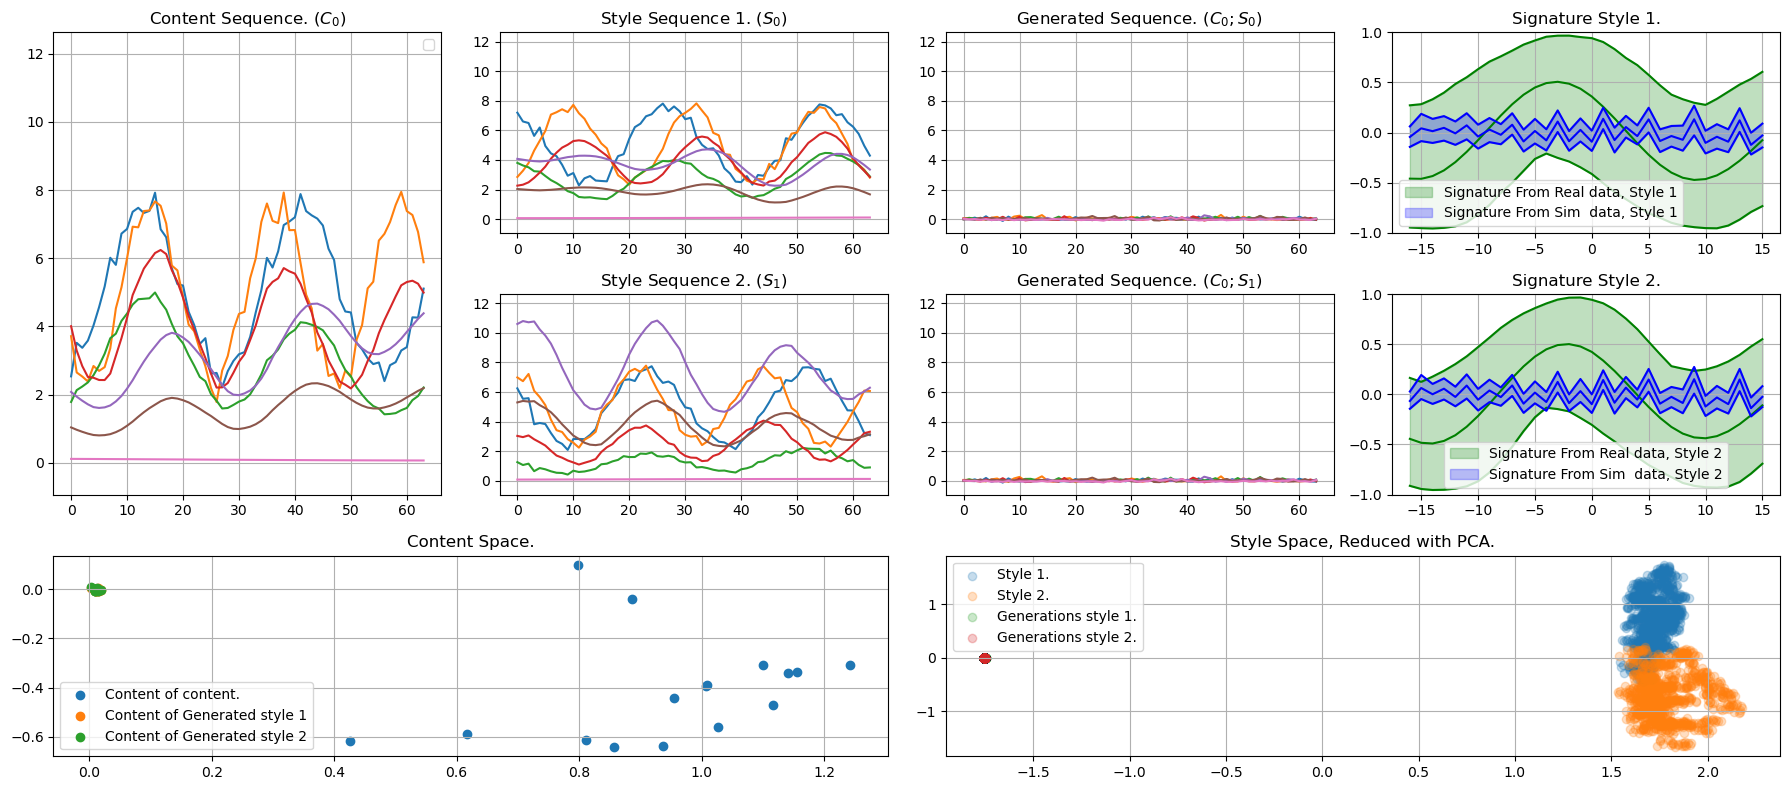

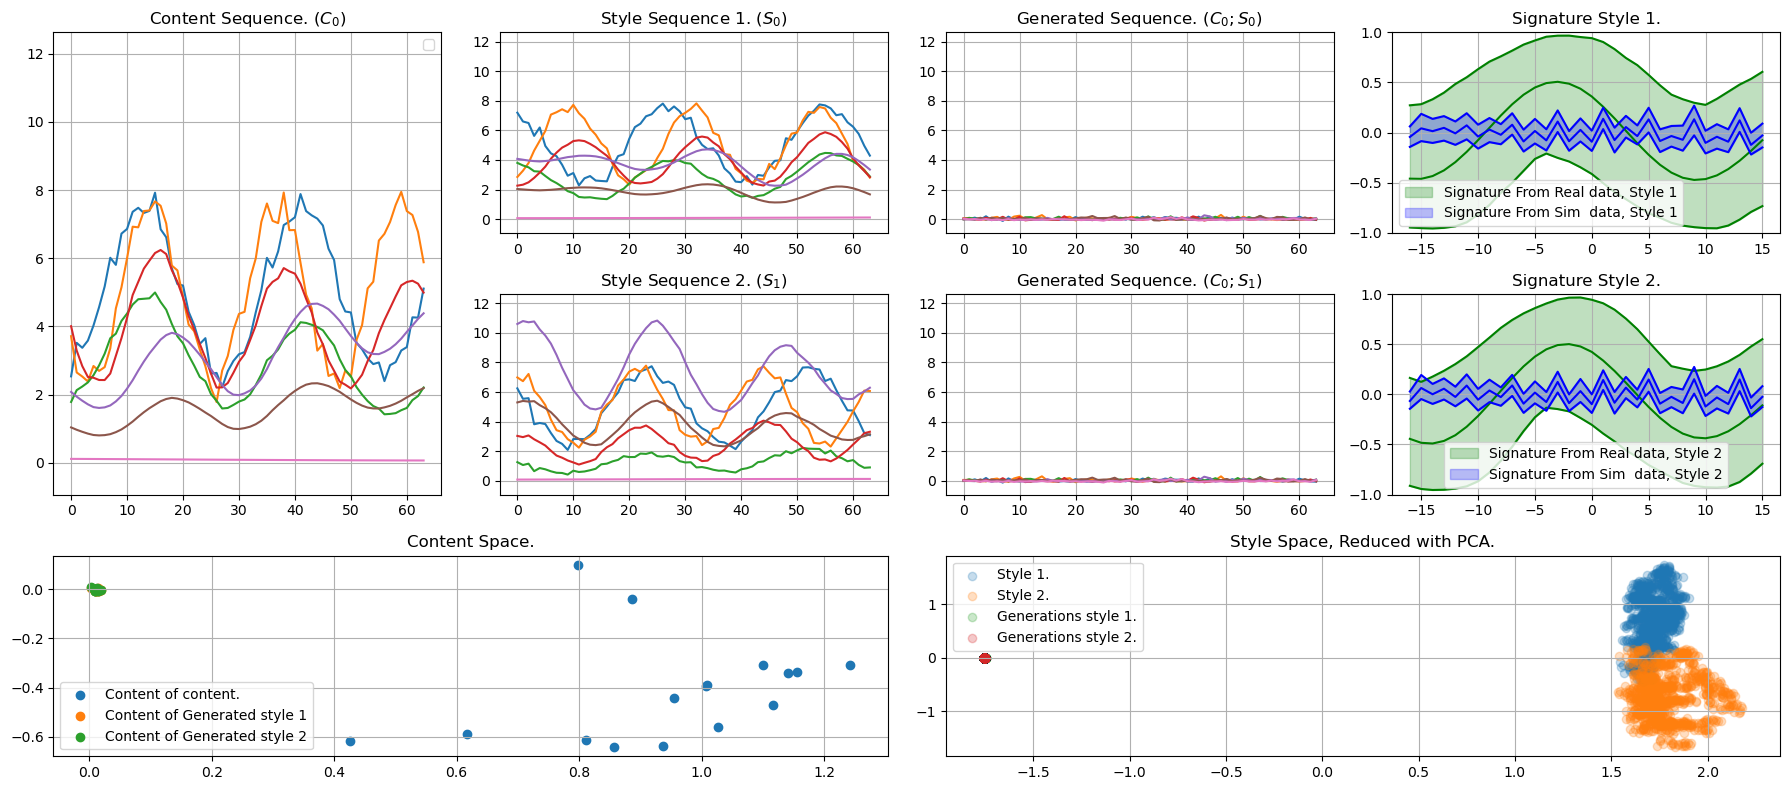

In [182]:
plot_generated_sequence2(
    content_encoder, style_encoder, decoder,
    seed_content_valid, 
    seed_style1_valid, 
    seed_style2_valid, 
    seed_style1_noise_train, 
    seed_style1_noise_valid, 
    seed_style2_noise_train, 
    seed_style2_noise_valid, 
    generated_s1_noise_train,
    generated_s1_noise_valid, 
    generated_s2_noise_train, 
    generated_s2_noise_valid
    )

In [134]:
def extract_amplitude_from_signals(batch):
    _mins = np.mean(np.min(batch, axis=1), axis=0)
    _maxs = np.mean(np.max(batch, axis=1), axis=0)

    return _maxs- _mins

def simple_amplitude_metric(reference_batch, generated_batch):
    ref_ampls = extract_amplitude_from_signals(reference_batch)
    gen_ampls = extract_amplitude_from_signals(generated_batch)

    return np.mean(np.abs(gen_ampls- ref_ampls))



## Define losses.

In [135]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
error_classif = tf.keras.losses.SparseCategoricalCrossentropy()

def recontruction_loss(true:tf.Tensor, generated:tf.Tensor):
    diff = generated- true
    result = tf.math.reduce_mean(tf.square(diff))
    return result

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = encoded_content_fake- encoded_content_real
    return tf.reduce_mean(tf.square(diff))

def style_classsification_loss(y_pred, y_true):
    return error_classif(y_true, y_pred)

## Tensorboard Logs.

In [136]:
# Train Metrics
# Generator Losses
met_generator_train = tf.keras.metrics.Mean(name="Total Generator Loss")

met_generator_reconstruction_train = tf.keras.metrics.Mean(name="Generator Reconstruction Loss")

met_generator_local_realness_train = tf.keras.metrics.Mean(name="Generator local Realness loss Train")
met_generator_global_realness_train = tf.keras.metrics.Mean(name="Generator Global Realness loss Train")

# Style Encoder Loss
met_triplet_train = tf.keras.metrics.Mean(name="Total Triplet Loss")
met_disentanglement_train = tf.keras.metrics.Mean(name="Disentanglement Loss")
met_style_encoder_train = tf.keras.metrics.Mean(name="Style Loss")

# Content encoder Loss
met_content_encoder_train= tf.keras.metrics.Mean(name="Content Encoder Loss")

# Central Discriminator
met_central_d_train= tf.keras.metrics.Mean(name="Central Discriminator Loss")
met_central_d_style_real_train = tf.keras.metrics.Mean(name="Central Discriminator Loss Real Style Classif")
met_central_d_style_fake_train = tf.keras.metrics.Mean(name="Central Discriminator Loss Fake Style Classif")

# Channel Discriminator.
met_channel_d_train= tf.keras.metrics.Mean(name="Channel Discriminator Loss")
met_channel_d_style_real_train = tf.keras.metrics.Mean(name="Channel Discriminator Real Style Classification")
met_channel_d_style_fake_train = tf.keras.metrics.Mean(name="Channel Discriminator Fake Style Classification")

# Correlation Metric
met_corr_style1_train = tf.keras.metrics.Mean(name="Correlation Metric Style 1")
met_corr_style2_train = tf.keras.metrics.Mean(name="Correlation Metric Style 2")

# Noise Extraction Metric
met_noise_sim_style1_train = tf.keras.metrics.Mean(name="Noise Similarity Style1.")
met_noise_sim_style2_train = tf.keras.metrics.Mean(name="Noise Similarity Style2.")

met_content_sim_style_1_train = tf.keras.metrics.Mean(name="Content Similarity Style1.")
met_content_sim_style_2_train = tf.keras.metrics.Mean(name="Content Similarity Style2.")

met_amplitude_sim_style1_train= tf.keras.metrics.Mean(name="Amplitude Similarity Style1.")
met_amplitude_sim_style2_train= tf.keras.metrics.Mean(name="Amplitude Similarity Style2.")

# Valid Metrics
# Generator Metric
met_generator_valid = tf.keras.metrics.Mean(name="Total Generator Loss")

met_generator_reconstruction_valid = tf.keras.metrics.Mean(name="Generator Reconstruction Loss")

met_generator_local_realness_valid = tf.keras.metrics.Mean(name="Generator local Realness loss valid")
met_generator_global_realness_valid = tf.keras.metrics.Mean(name="Generator Global Realness loss valid")

# Style Encoder Loss
met_triplet_valid = tf.keras.metrics.Mean(name="Total Triplet Loss")
met_disentanglement_valid = tf.keras.metrics.Mean(name="Disentanglement Loss")
met_style_encoder_valid = tf.keras.metrics.Mean(name="Style Loss")

# Content encoder Loss
met_content_encoder_valid= tf.keras.metrics.Mean(name="Content Encoder Loss")

# Central Discriminator
met_central_d_valid= tf.keras.metrics.Mean(name="Central Discriminator Loss")
met_central_d_style_real_valid = tf.keras.metrics.Mean(name="Central Discriminator Loss Real Style Classif")
met_central_d_style_fake_valid = tf.keras.metrics.Mean(name="Central Discriminator Loss Fake Style Classif")

# Channel Discriminator.
met_channel_d_valid= tf.keras.metrics.Mean(name="Channel Discriminator Loss")
met_channel_d_style_real_valid = tf.keras.metrics.Mean(name="Channel Discriminator Real Style Classification")
met_channel_d_style_fake_valid = tf.keras.metrics.Mean(name="Channel Discriminator Fake Style Classification")

# Correlation Metric
met_corr_style1_valid = tf.keras.metrics.Mean(name="Correlation Metric Style 1")
met_corr_style2_valid = tf.keras.metrics.Mean(name="Correlation Metric Style 2")

met_noise_sim_style1_valid = tf.keras.metrics.Mean(name="Noise Similarity Style1.")
met_noise_sim_style2_valid = tf.keras.metrics.Mean(name="Noise Similarity Style2.")

met_content_sim_style_1_valid = tf.keras.metrics.Mean(name="Content Similarity Style1.")
met_content_sim_style_2_valid = tf.keras.metrics.Mean(name="Content Similarity Style2.")

met_amplitude_sim_style1_valid= tf.keras.metrics.Mean(name="Amplitude Similarity Style1.")
met_amplitude_sim_style2_valid= tf.keras.metrics.Mean(name="Amplitude Similarity Style2.")

In [137]:
TRAIN_SUMMARY_WRITER = tf.summary.create_file_writer(TRAIN_LOGS_DIR_PATH)
VALID_SUMMARY_WRITER = tf.summary.create_file_writer(VALID_LOGS_DIR_PATH)

def log_train_losses(epoch, plot_buf):
    image = tf.image.decode_png(plot_buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    with TRAIN_SUMMARY_WRITER.as_default():
        tf.summary.scalar("00 - Correlation Metric Style 1", met_corr_style1_train.result(), step=epoch)
        tf.summary.scalar("01 - Correlation Metric Style 2", met_corr_style2_train.result(), step=epoch)

        tf.summary.scalar("02 - Noise Similarity Style 1", met_noise_sim_style1_train.result(), step=epoch)
        tf.summary.scalar("03 - Noise Similarity Style 2", met_noise_sim_style2_train.result(), step=epoch)

        tf.summary.scalar("04 - Content Similarity Style 1", met_content_sim_style_1_train.result(), step=epoch)
        tf.summary.scalar("05 - Content Similarity Style 2", met_content_sim_style_2_train.result(), step=epoch)
        
        tf.summary.scalar("06 - Amplitude Similarity Style 1", met_amplitude_sim_style1_train.result(), step=epoch)
        tf.summary.scalar("07 - Amplitude Similarity Style 2", met_amplitude_sim_style2_train.result(), step=epoch)

        tf.summary.scalar("10 - Total Generator Loss", met_generator_train.result(), step=epoch)
        tf.summary.scalar("11 - Reconstruction from Content", met_generator_reconstruction_train.result(), step=epoch)

        tf.summary.scalar("12 - Central Realness", met_generator_global_realness_train.result(), step=epoch)
        tf.summary.scalar("13 - Local Realness", met_generator_local_realness_train.result(), step=epoch)

        tf.summary.scalar("20 - Style Loss", met_style_encoder_train.result(), step=epoch)
        tf.summary.scalar("21 - Triplet Loss", met_triplet_train.result(), step=epoch)
        tf.summary.scalar("22 - Disentanglement Loss", met_disentanglement_train.result(), step=epoch)

        tf.summary.scalar("30 - Content Loss", met_content_encoder_train.result(), step=epoch)

        tf.summary.scalar("40 - Global Discriminator Loss", met_central_d_train.result(), step=epoch)
        tf.summary.scalar("40 - Local Discriminator Loss", met_channel_d_train.result(), step=epoch)

        tf.summary.scalar("41 - Global Discriminator Style Loss (Real Data)", met_central_d_style_real_train.result(), step=epoch)
        tf.summary.scalar("41 - Global Discriminator Style Loss (Fake Data)", met_central_d_style_fake_train.result(), step=epoch)

        tf.summary.scalar("42 - Local Discriminator Style Loss (Real Data)", met_channel_d_style_real_train.result(), step=epoch)
        tf.summary.scalar("42 - Local Discriminator Style Loss (Fake Data)", met_channel_d_style_fake_train.result(), step=epoch)



        tf.summary.image("Training Generations", image, step=epoch)


def log_valid_losses(epoch):
    with VALID_SUMMARY_WRITER.as_default():
        tf.summary.scalar("00 - Correlation Metric Style 1", met_corr_style1_valid.result(), step=epoch)
        tf.summary.scalar("01 - Correlation Metric Style 2", met_corr_style2_valid.result(), step=epoch)

        tf.summary.scalar("02 - Noise Similarity Style 1", met_noise_sim_style1_valid.result(), step=epoch)
        tf.summary.scalar("03 - Noise Similarity Style 2", met_noise_sim_style2_valid.result(), step=epoch)

        tf.summary.scalar("04 - Content Similarity Style 1", met_content_sim_style_1_valid.result(), step=epoch)
        tf.summary.scalar("05 - Content Similarity Style 2", met_content_sim_style_2_valid.result(), step=epoch)

        tf.summary.scalar("06 - Amplitude Similarity Style 1", met_amplitude_sim_style1_valid.result(), step=epoch)
        tf.summary.scalar("07 - Amplitude Similarity Style 2", met_amplitude_sim_style2_valid.result(), step=epoch)

        tf.summary.scalar("10 - Total Generator Loss", met_generator_valid.result(), step=epoch)
        tf.summary.scalar("11 - Reconstruction from Content", met_generator_reconstruction_valid.result(), step=epoch)

        tf.summary.scalar("12 - Central Realness", met_generator_global_realness_valid.result(), step=epoch)
        tf.summary.scalar("13 - Local Realness", met_generator_local_realness_valid.result(), step=epoch)

        tf.summary.scalar("20 - Style Loss", met_style_encoder_valid.result(), step=epoch)
        tf.summary.scalar("21 - Triplet Loss", met_triplet_valid.result(), step=epoch)
        tf.summary.scalar("22 - Disentanglement Loss", met_disentanglement_valid.result(), step=epoch)

        tf.summary.scalar("30 - Content Loss", met_content_encoder_valid.result(), step=epoch)

        tf.summary.scalar("40 - Global Discriminator Loss", met_central_d_valid.result(), step=epoch)
        tf.summary.scalar("40 - Local Discriminator Loss", met_channel_d_valid.result(), step=epoch)

        tf.summary.scalar("41 - Global Discriminator Style Loss (Real Data)", met_central_d_style_real_valid.result(), step=epoch)
        tf.summary.scalar("41 - Global Discriminator Style Loss (Fake Data)", met_central_d_style_fake_valid.result(), step=epoch)

        tf.summary.scalar("42 - Local Discriminator Style Loss (Real Data)", met_channel_d_style_real_valid.result(), step=epoch)
        tf.summary.scalar("42 - Local Discriminator Style Loss (Fake Data)", met_channel_d_style_fake_valid.result(), step=epoch)
        

def reset_metric_states():
    met_generator_train.reset_states()
    met_generator_reconstruction_train.reset_states()
    met_generator_local_realness_train.reset_states()
    met_generator_global_realness_train.reset_states()
    met_triplet_train.reset_states()
    met_disentanglement_train.reset_states()
    met_style_encoder_train.reset_states()
    met_content_encoder_train.reset_states()
    met_central_d_train.reset_states()
    met_central_d_style_real_train.reset_states()
    met_central_d_style_fake_train.reset_states()
    met_channel_d_train.reset_states()
    met_channel_d_style_real_train.reset_states()
    met_channel_d_style_fake_train.reset_states()
    met_corr_style1_train.reset_states()
    met_corr_style2_train.reset_states()
    met_noise_sim_style1_train.reset_states()
    met_noise_sim_style2_train.reset_states()
    
    met_amplitude_sim_style1_train.reset_states()
    met_amplitude_sim_style2_train.reset_states()



def reset_valid_states():
    met_generator_valid.reset_states()
    met_generator_reconstruction_valid.reset_states()
    met_generator_local_realness_valid.reset_states()
    met_generator_global_realness_valid.reset_states()
    met_triplet_valid.reset_states()
    met_disentanglement_valid.reset_states()
    met_style_encoder_valid.reset_states()
    met_content_encoder_valid.reset_states()
    met_central_d_valid.reset_states()
    met_central_d_style_real_valid.reset_states()
    met_central_d_style_fake_valid.reset_states()
    met_channel_d_valid.reset_states()
    met_channel_d_style_real_valid.reset_states()
    met_channel_d_style_fake_valid.reset_states()
    met_corr_style1_valid.reset_states()
    met_corr_style2_valid.reset_states()
    met_noise_sim_style1_valid.reset_states()
    met_noise_sim_style2_valid.reset_states()
    
    met_amplitude_sim_style1_valid.reset_states()
    met_amplitude_sim_style2_valid.reset_states()

## Instantiate model for training.

In [138]:
# opt_content_encoder = tf.keras.optimizers.Adam(learning_rate=0.001)
# opt_style_encoder = tf.keras.optimizers.Adam(learning_rate=0.001)
# opt_decoder = tf.keras.optimizers.Adam(learning_rate=0.002)
# local_discriminator_opt = tf.keras.optimizers.Adam(learning_rate=0.002)
# global_discriminator_opt = tf.keras.optimizers.Adam(learning_rate=0.002)

opt_content_encoder = tf.keras.optimizers.RMSprop(learning_rate=0.001)
opt_style_encoder = tf.keras.optimizers.RMSprop(learning_rate=0.001)
opt_decoder = tf.keras.optimizers.RMSprop(learning_rate=0.002)
local_discriminator_opt = tf.keras.optimizers.RMSprop(learning_rate=0.002)
global_discriminator_opt = tf.keras.optimizers.RMSprop(learning_rate=0.002)

## Train the model

In [139]:
from itertools import product
indexes = np.array(list(product(range(BS), range(BS))))
other_index = np.arange(BS)* BS

In [140]:
anchor_indexes = np.array([ i* BS+i for i in range(BS) for _ in range(BS) ])
pos_indexes = np.array([ BS*j + i for i in range(BS) for j in range(BS)])
neg_indexes = np.array([ (j*BS + (i+1)%BS) for i in range(BS) for j in range(BS)])

In [141]:
def get_style_voctor_for_dis_loss(style_vector:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    return tf.gather(style_vector, anchor_indexes)

def get_anchor_positive_negative_from_batch(style_from_style_ts:tf.Tensor, style_of_generations:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size)])
    neg_indexes = np.array([ (j*batch_size + (i+1)%batch_size) for i in range(batch_size) for j in range(batch_size)])

    # Anchor are for example:
    # [(c0, s0), (c0, s0), 
    # (c1, s1), (c1, s1), ...]
    anchors = tf.gather(style_from_style_ts, anchor_indexes)
    # Different content, Same Style:
    # [(c1, s0), (c2, s0),(c2, s0),
    #  (c1, s1), (c2, s1), (c3, s1)...]
    # E_s(G(x, y1))
    pos_vector= tf.gather(style_of_generations, pos_indexes)
    # Same content but different style
    # [(c1, s1), (c2, s1),(c2, s1),
    #  (c1, s2), (c2, s2), (c3, s2)...]
    # # E_s(G(x, y2)) 
    neg_vector = tf.gather(style_of_generations, neg_indexes)

    return anchors, pos_vector, neg_vector

def get_dissantanglement_loss_component(style_of_generations, style_of_style, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size) if i !=j ])

    es_y = tf.gather(style_of_style, anchor_indexes)
    es_x1_y = tf.gather(style_of_generations, anchor_indexes)
    es_x2_y = tf.gather(style_of_generations, pos_indexes)

    return es_y, es_x1_y, es_x2_y


def l2(x:tf.Tensor, y:tf.Tensor):
    diff = tf.square(y- x)
    _distance = tf.reduce_sum(diff, axis=-1)
    return _distance


def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = l2(encoded_content_real, encoded_content_fake)
    return tf.reduce_mean(diff)

def fixed_point_triplet_style_loss(anchor_encoded_style, positive_encoded_style, negative_encoded_style):
    # shape: [BS, Style_length]
    negative_distance = l2(negative_encoded_style, anchor_encoded_style)
    positive_distance = l2(positive_encoded_style, anchor_encoded_style)

    triplet = TRIPLET_R+ positive_distance- negative_distance
    zeros = tf.zeros_like(triplet)
    triplet = tf.math.maximum(triplet, zeros)

    loss = tf.reduce_mean(triplet)
    return loss

def fixed_point_disentanglement(
        es_x1_y:tf.Tensor, 
        es_x2_y:tf.Tensor, 
        es_y:tf.Tensor
        ):

    diff1 = l2(es_x1_y, es_x2_y)
    diff2 = l2(es_x1_y, es_y)

    loss = diff1- diff2
    zeros = tf.zeros_like(loss)
    loss = tf.math.maximum(loss, zeros)
    loss = tf.reduce_mean(loss)
    return loss


def style_constrain_loss(style_of_style_batch, style_of_generation):
    diff = l2(style_of_style_batch, style_of_generation)
    diff = tf.reduce_mean(diff)
    return diff

In [142]:
bc = tf.keras.losses.BinaryCrossentropy()
error_classif = tf.keras.losses.SparseCategoricalCrossentropy()

def local_discriminator_loss(crits_on_real, crits_on_fake):
    individual_losses = []

    for i in range(crits_on_real.shape[0]):
        l1 = bc(tf.zeros_like(crits_on_real), crits_on_fake[i])
        l2 = bc(tf.ones_like(crits_on_real), crits_on_real[i])
        loss = (l1+ l2)/2
        individual_losses.append(loss)
        
    return individual_losses


def local_generator_loss(crit_on_fake):
    individual_losses = []
    true_label = tf.zeros(crit_on_fake[0].shape)

    for i in range(crit_on_fake.shape[0]):
        individual_losses.append(bc(true_label, crit_on_fake[i]))
        
    return tf.reduce_mean(individual_losses)


def style_classsification_loss(y_pred, y_true):
    return error_classif(y_true, y_pred)


def global_discriminator_loss(crit_on_real, crit_on_fake):
    l1 = bc(tf.zeros_like(crit_on_fake), crit_on_fake)
    l2 = bc(tf.ones_like(crit_on_real), crit_on_real)
    loss = (l1+ l2)/2

    return loss


def global_generator_loss(crit_on_fake):
    loss = bc(tf.ones_like(crit_on_fake), crit_on_fake)
    return loss

In [143]:
def _pairwise_distance(a_embeddings, b_embeddings):
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(a_embeddings, tf.transpose(b_embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    return distances

def get_positives(labels):
    # will assign 1 where this is a positive 
    positive_mask = np.array([ tf.cast(labels == l, tf.float32) for l in labels])
    positive_mask = positive_mask - np.identity(positive_mask.shape[0])
    return positive_mask

def get_negative(labels):
    neg_labels= np.array([ tf.cast(labels != l, tf.float32) for l in labels])
    return neg_labels


def get_triplet_loss(anchor_embedding, positive_embedding, negative_embedding):
    positive_distance= _pairwise_distance(anchor_embedding, positive_embedding)
    negative_distance= _pairwise_distance(anchor_embedding, negative_embedding)

    positive_index= tf.argmax(positive_distance, axis=1)

    pos_embedding = tf.gather(positive_embedding, positive_index)
 
    neg_indexes = tf.argmin(negative_distance, axis=1)
    
    neg_embeddings= tf.gather(negative_embedding, neg_indexes)

    positive_distances= l2(anchor_embedding, pos_embedding)
    negative_distances= l2(anchor_embedding, neg_embeddings)

    loss = tf.reduce_mean(tf.maximum(TRIPLET_R+ positive_distances - negative_distances, 0))

    return loss

def compute_metric(generated_style:tf.Tensor, true_style:tf.Tensor):
    true_signature = signature_on_batch(true_style, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    generated_signature= signature_on_batch(generated_style, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)

    return signature_metric(true_signature, generated_signature)

In [144]:
@tf.function
def discriminator_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences):
    # Discriminator Step
    with tf.GradientTape(persistent=True) as discr_tape:
        # Sequence generations.
        c1 = content_encoder(content_sequence1, training=False)

        s1 = style_encoder(style1_sequences, training=False)
        s2 = style_encoder(style2_sequences, training=False)

        style1_generated= decoder([c1, s1], training=False)
        style2_generated= decoder([c1, s2], training=False)

        # Global on Real
        g_crit_real1, g_style_classif_real1 = global_discriminator(style1_sequences, training=True)
        g_crit_real2, g_style_classif_real2 = global_discriminator(style2_sequences, training=True)

        # Global on Generated
        g_crit_fake1, _ = global_discriminator(style1_generated, training=True)
        g_crit_fake2, _ = global_discriminator(style2_generated, training=True)

        # Local on Real
        l_crit1_real = local_discriminator(style1_sequences, training=True)
        l_crit2_real = local_discriminator(style2_sequences, training=True)

        # Local on fake
        l_crit_fake1 = local_discriminator(style1_generated, training=True)
        l_crit_fake2 = local_discriminator(style2_generated, training=True)

        # Compute the loss for GLOBAL the Discriminator
        g_crit_loss1 = discriminator_loss(g_crit_real1, g_crit_fake1)
        g_crit_loss2 = discriminator_loss(g_crit_real2, g_crit_fake2)

        g_crit_loss = tf.stack((g_crit_loss1, g_crit_loss2))
        g_crit_loss = tf.reduce_mean(g_crit_loss, 0)
        
        style_labels = tf.zeros((BS, 1))
        g_style1_real = style_classsification_loss(g_style_classif_real1, style_labels+ 0.)
        g_style2_real = style_classsification_loss(g_style_classif_real2, style_labels +1.)
        g_style_real = tf.stack((g_style1_real, g_style2_real))
        g_style_real = tf.reduce_mean(g_style_real, 0)

        l_loss1 = local_discriminator_loss(l_crit1_real, l_crit_fake1)
        l_loss2 = local_discriminator_loss(l_crit2_real, l_crit_fake2)

        l_loss = tf.stack((l_loss1, l_loss2))
        l_loss = tf.reduce_mean(l_loss, 0)

    # (GOBAL DISCRIMINATOR): Real / Fake and style
    global_discr_gradient = discr_tape.gradient([g_crit_loss, g_style_real], global_discriminator.trainable_variables)
    global_discriminator_opt.apply_gradients(zip(global_discr_gradient, global_discriminator.trainable_variables)) 
    
    grads = discr_tape.gradient(l_loss, local_discriminator.trainable_variables)
    local_discriminator_opt.apply_gradients(zip(grads, local_discriminator.trainable_variables))

    met_central_d_train(g_crit_loss)
    met_central_d_style_real_train(g_style_real)

    met_channel_d_train(l_loss)

    
@tf.function
def     generator_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences):

    # Here, things get a little bit more complicated :)
    with tf.GradientTape() as content_tape, tf.GradientTape() as style_tape, tf.GradientTape() as decoder_tape:
        contents = tf.concat([content_sequence1, content_sequence2], 0)
        cs = content_encoder(contents, training=True)
        s_cs = style_encoder(contents, training=True)
        id_generated = decoder([cs, s_cs], training=True)
        reconstr_loss = recontruction_loss(contents, id_generated)

        ####
        contents = tf.concat([content_sequence1, content_sequence2, content_sequence1, content_sequence2], 0)
        styles = tf.concat([style1_sequences, style1_sequences, style2_sequences, style2_sequences], 0)
        _bs = content_sequence1.shape[0]

        encoded_content= content_encoder(contents, training=True)
        encoded_styles = style_encoder(styles, training=True)

        generations = decoder([encoded_content, encoded_styles], training=True)

        s_generations = style_encoder(generations, training=True)
        c_generations = content_encoder(generations, training=True)
        
        style_labels = np.zeros((4* _bs,))
        style_labels[2* _bs:]= 1.

        # Discriminator pass for the adversarial loss for the generator.
        crit_on_fake, style_classif_fakes = global_discriminator(generations, training=False)

        # Local Discriminator on Fake Data.
        l_crit_on_fake = local_discriminator(generations, training=False)


        # Channel Discriminator losses
        local_realness_loss = local_generator_loss(l_crit_on_fake)
        
        # Global Generator losses.
        global_style_loss = style_classsification_loss(style_classif_fakes, style_labels)
        global_realness_loss = generator_loss(crit_on_fake)


        c1s = tf.concat([
            encoded_content[:_bs],                  # 2
            encoded_content[2*_bs:3* _bs]           # 3
        ], 0)

        c2s = tf.concat([
            encoded_content[_bs:2* _bs],            # 2
            encoded_content[3*_bs:]                 # 4 
        ], 0)

        generated_c1s = tf.concat([
            c_generations[:_bs],
            c_generations[2*_bs:3* _bs]
        ], 0)

        generated_c2s = tf.concat([
            c_generations[_bs:2* _bs],
            c_generations[3*_bs:]
        ], 0)

        s_c1_s1 = s_generations[:_bs]
        s_c1_s2 = s_generations[2*_bs: 3*_bs]
        s_c2_s2 = s_generations[3*_bs:] 

        s1s = encoded_styles[:_bs]
        s2s = encoded_styles[2* _bs:3* _bs]

        content_preservation1 = fixed_point_content(c1s, generated_c1s)
        content_preservation2 = fixed_point_content(c2s, generated_c2s)
        content_preservation = (content_preservation1+ content_preservation2)/2

        triplet_style =  get_triplet_loss(s1s, s_c1_s1, s_c1_s2)
        content_style_disentenglement = fixed_point_disentanglement(s_c2_s2, s_c1_s2, s2s)

        content_encoder_loss = L_CONTENT* content_preservation
        style_encoder_loss = L_TRIPLET* triplet_style + L_DIS* content_style_disentenglement

        g_loss = L_RECONSTR* reconstr_loss+ L_GLOBAL* global_realness_loss + L_STYLE_PRESERVATION* global_style_loss + L_LOCAL* local_realness_loss

    # Make the Networks Learn!
    content_grad=content_tape.gradient(content_encoder_loss, content_encoder.trainable_variables)
    style_grad = style_tape.gradient(style_encoder_loss, style_encoder.trainable_variables)
    decoder_grad = decoder_tape.gradient(g_loss, decoder.trainable_variables)
        
    opt_content_encoder.apply_gradients(zip(content_grad, content_encoder.trainable_variables))
    opt_style_encoder.apply_gradients(zip(style_grad, style_encoder.trainable_variables))
    opt_decoder.apply_gradients(zip(decoder_grad, decoder.trainable_variables))

    met_generator_train(g_loss)
    met_generator_reconstruction_train(reconstr_loss)

    met_generator_local_realness_train(local_realness_loss)
    met_generator_global_realness_train(global_realness_loss)

    met_central_d_style_fake_train(global_style_loss)

    met_disentanglement_train(content_style_disentenglement)
    met_triplet_train(triplet_style)
    met_style_encoder_train(style_encoder_loss)
    met_content_encoder_train(content_preservation)

In [145]:
@tf.function
def generator_valid(content_sequence1, content_sequence2, style1_sequences, style2_sequences):
    contents = tf.concat([content_sequence1, content_sequence2], 0)
    cs = content_encoder(contents, training=True)
    s_cs = style_encoder(contents, training=True)
    id_generated = decoder([cs, s_cs], training=True)
    reconstr_loss = recontruction_loss(contents, id_generated)

    ####
    contents = tf.concat([content_sequence1, content_sequence2, content_sequence1, content_sequence2], 0)
    styles = tf.concat([style1_sequences, style1_sequences, style2_sequences, style2_sequences], 0)
    _bs = content_sequence1.shape[0]

    encoded_content= content_encoder(contents, training=True)
    encoded_styles = style_encoder(styles, training=True)

    generations = decoder([encoded_content, encoded_styles], training=True)

    s_generations = style_encoder(generations, training=True)
    c_generations = content_encoder(generations, training=True)
    
    style_labels = np.zeros((4* _bs,))
    style_labels[2* _bs:]= 1.

    # Discriminator pass for the adversarial loss for the generator.
    crit_on_fake, style_classif_fakes = global_discriminator(generations, training=False)

    # Local Discriminator on Fake Data.
    l_crit_on_fake = local_discriminator(generations, training=False)


    # Channel Discriminator losses
    local_realness_loss = local_generator_loss(l_crit_on_fake)
    
    # Global Generator losses.
    global_style_loss = style_classsification_loss(style_classif_fakes, style_labels)
    global_realness_loss = generator_loss(crit_on_fake)


    c1s = tf.concat([
        encoded_content[:_bs],                  # 2
        encoded_content[2*_bs:3* _bs]           # 3
    ], 0)

    c2s = tf.concat([
        encoded_content[_bs:2* _bs],            # 2
        encoded_content[3*_bs:]                 # 4 
    ], 0)

    generated_c1s = tf.concat([
        c_generations[:_bs],
        c_generations[2*_bs:3* _bs]
    ], 0)

    generated_c2s = tf.concat([
        c_generations[_bs:2* _bs],
        c_generations[3*_bs:]
    ], 0)

    s_c1_s1 = s_generations[:_bs]
    s_c1_s2 = s_generations[2*_bs: 3*_bs]
    s_c2_s2 = s_generations[3*_bs:] 

    s1s = encoded_styles[:_bs]
    s2s = encoded_styles[2* _bs:3* _bs]

    content_preservation1 = fixed_point_content(c1s, generated_c1s)
    content_preservation2 = fixed_point_content(c2s, generated_c2s)
    content_preservation = (content_preservation1+ content_preservation2)/2

    triplet_style =  get_triplet_loss(s1s, s_c1_s1, s_c1_s2)
    content_style_disentenglement = fixed_point_disentanglement(s_c2_s2, s_c1_s2, s2s)

    style_encoder_loss = L_TRIPLET* triplet_style + L_DIS* content_style_disentenglement

    g_loss = L_RECONSTR* reconstr_loss+ L_GLOBAL* global_realness_loss + L_GLOBAL* global_style_loss + L_LOCAL* local_realness_loss
    
    met_generator_valid(g_loss)
    met_generator_reconstruction_valid(reconstr_loss)

    met_generator_local_realness_valid(local_realness_loss)
    met_generator_global_realness_valid(global_realness_loss)

    met_central_d_style_fake_valid(global_style_loss)

    met_content_encoder_valid(content_preservation)
    
    met_style_encoder_valid(style_encoder_loss)
    met_triplet_valid(triplet_style)
    met_disentanglement_valid(content_style_disentenglement)
    

@tf.function
def discriminator_valid(content_sequence1, content_sequence2, style1_sequences, style2_sequences):
    c1 = content_encoder(content_sequence1, training=False)

    s1 = style_encoder(style1_sequences, training=False)
    s2 = style_encoder(style2_sequences, training=False)

    style1_generated= decoder([c1, s1], training=False)
    style2_generated= decoder([c1, s2], training=False)

    # Global on Real
    g_crit_real1, g_style_classif_real1 = global_discriminator(style1_sequences, training=True)
    g_crit_real2, g_style_classif_real2 = global_discriminator(style2_sequences, training=True)

    # Global on Generated
    g_crit_fake1, _ = global_discriminator(style1_generated, training=True)
    g_crit_fake2, _ = global_discriminator(style2_generated, training=True)

    # Local on Real
    l_crit1_real = local_discriminator(style1_sequences, training=True)
    l_crit2_real = local_discriminator(style2_sequences, training=True)

    # Local on fake
    l_crit_fake1 = local_discriminator(style1_generated, training=True)
    l_crit_fake2 = local_discriminator(style2_generated, training=True)

    # Compute the loss for GLOBAL the Discriminator
    g_crit_loss1 = discriminator_loss(g_crit_real1, g_crit_fake1)
    g_crit_loss2 = discriminator_loss(g_crit_real2, g_crit_fake2)

    g_crit_loss = tf.stack((g_crit_loss1, g_crit_loss2))
    g_crit_loss = tf.reduce_mean(g_crit_loss, 0)
    
    style_labels = tf.zeros((content_sequence1.shape[0], 1))
    g_style1_real = style_classsification_loss(g_style_classif_real1, style_labels+ 0.)
    g_style2_real = style_classsification_loss(g_style_classif_real2, style_labels +1.)
    g_style_real = tf.stack((g_style1_real, g_style2_real))
    g_style_real = tf.reduce_mean(g_style_real, 0)

    l_loss1 = local_discriminator_loss(l_crit1_real, l_crit_fake1)
    l_loss2 = local_discriminator_loss(l_crit2_real, l_crit_fake2)

    l_loss = tf.stack((l_loss1, l_loss2))
    l_loss = tf.reduce_mean(l_loss, 0)

    met_central_d_valid(g_crit_loss)
    met_central_d_style_real_valid(g_style_real)

    met_channel_d_valid(l_loss)


In [146]:
def train():
    total_batch = "?"
    for e in range(EPOCHS):
        reset_metric_states()
        # reset_valid_states()
        
        print("[+] Train Step...")
        for i, (content_batch, style1_sequences, style2_sequences) in enumerate(zip(content_dset_train, style1_dset_train, style2_dset_train)):
            content_sequence1 = content_batch[:int(BS)]
            content_sequence2 = content_batch[int(BS):]

            if i%DISCR_STEP == 0:
                discriminator_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences)

            generator_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences)
            
            print(f"\r e:{e}/{EPOCHS}; {i}/{total_batch}. G_loss {met_generator_train.result():0.2f}; Triplet Loss {met_triplet_train.result():0.2f}; Disentanglement Loss: {met_disentanglement_train.result():0.2f}; Content Loss {met_content_encoder_train.result():0.2f} Local D [Crit; Style]: [{met_channel_d_train.result():0.2f}; {met_channel_d_style_real_train.result():0.2f}]; Global D [Crit; Style]: [{met_central_d_train.result():0.2f}; {met_central_d_style_fake_train.result():0.2f}]       ", end="")

        print()
        print("[+] Validation Step...")
        for vb, (content_batch, style1_sequences, style2_sequences) in enumerate(zip(content_dset_valid, style1_dset_valid, style2_dset_valid)):
            content_sequence1 = content_batch[:int(BS)]
            content_sequence2 = content_batch[int(BS):]

            discriminator_valid(content_sequence1, content_sequence2, style1_sequences, style2_sequences)
            generator_valid(content_sequence1, content_sequence2, style1_sequences, style2_sequences)

            print(f"\r e:{e}/{EPOCHS}; {vb}/{total_batch}. G_loss {met_generator_valid.result():0.2f}; Triplet Loss {met_triplet_valid.result():0.2f}; Disentanglement Loss: {met_disentanglement_valid.result():0.2f}; Content Loss {met_content_encoder_valid.result():0.2f} Local D [Crit; Style]: [{met_channel_d_valid.result():0.2f}; {met_channel_d_style_real_valid.result():0.2f}]; Global D [Crit; Style]: [{met_central_d_valid.result():0.2f}; {met_central_d_style_fake_valid.result():0.2f}]       ", end="")
    
        # Make Generations Train Set
        generation_style1_train = generate(seed_content_train, seed_style1_train)
        generation_style1_valid = generate(seed_content_valid, seed_style1_valid)

        generation_style2_train = generate(seed_content_train, seed_style2_train)
        generation_style2_valid = generate(seed_content_valid, seed_style2_valid)
        
        metric_s1_train = compute_metric(generation_style1_train, seed_style1_train)
        metric_s1_valid = compute_metric(generation_style1_valid, seed_style1_valid)

        metric_s2_train = compute_metric(generation_style2_train, seed_style2_train)
        metric_s2_valid = compute_metric(generation_style2_valid, seed_style2_valid)
        
        met_corr_style1_train(metric_s1_train)
        met_corr_style2_train(metric_s2_train)

        met_corr_style1_valid(metric_s1_valid)
        met_corr_style2_valid(metric_s2_valid)

        # Compute the simple metric specificaly made for noise domain shift.
        content_gen_style1_train, generated_s1_noise_train = simple_metric_on_noise(generation_style1_train)
        content_gen_style1_valid, generated_s1_noise_valid = simple_metric_on_noise(generation_style1_valid)

        content_gen_style2_train, generated_s2_noise_train = simple_metric_on_noise(generation_style2_train)
        content_gen_style2_valid, generated_s2_noise_valid = simple_metric_on_noise(generation_style2_valid)

        style1_ampl_diff_train = simple_amplitude_metric(seed_style1_train, generation_style1_train)
        style1_ampl_diff_valid = simple_amplitude_metric(seed_style1_valid, generation_style1_valid)

        style2_ampl_diff_train = simple_amplitude_metric(seed_style2_train, generation_style2_train)
        style2_ampl_diff_valid = simple_amplitude_metric(seed_style2_valid, generation_style2_valid)

        met_amplitude_sim_style1_train(style1_ampl_diff_train)
        met_amplitude_sim_style2_train(style2_ampl_diff_train)
        met_amplitude_sim_style1_valid(style1_ampl_diff_valid)
        met_amplitude_sim_style2_valid(style2_ampl_diff_valid)

        met_noise_sim_style1_train(np.mean(np.abs(seed_style1_noise_train - generated_s1_noise_train)))
        met_noise_sim_style1_valid(np.mean(np.abs(seed_style1_noise_valid - generated_s1_noise_valid)))

        met_noise_sim_style2_train(np.mean(np.abs(seed_style2_noise_train - generated_s2_noise_train)))
        met_noise_sim_style2_valid(np.mean(np.abs(seed_style2_noise_valid - generated_s2_noise_valid)))

        met_content_sim_style_1_train(np.mean(np.abs(seed_content_trends_train - content_gen_style1_train)))
        met_content_sim_style_2_train(np.mean(np.abs(seed_content_trends_train - content_gen_style2_train)))
        
        met_content_sim_style_1_valid(np.mean(np.abs(seed_content_trends_valid - content_gen_style1_valid)))
        met_content_sim_style_2_valid(np.mean(np.abs(seed_content_trends_valid - content_gen_style2_valid)))


        vis_fig = plot_generated_sequence2(
            content_encoder, style_encoder, decoder,
            seed_content_valid, 
            seed_style1_valid, 
            seed_style2_valid, 
            seed_style1_noise_train, 
            seed_style1_noise_valid, 
            seed_style2_noise_train, 
            seed_style2_noise_valid, 
            generated_s1_noise_train,
            generated_s1_noise_valid, 
            generated_s2_noise_train, 
            generated_s2_noise_valid
            )
        plot_buff = fig_to_buff(vis_fig)
        
        print("\n******* Signature Difference *******")
        print(f"Style 1:")
        print(f"Train: {metric_s1_train:0.2f}; Valid: {metric_s1_valid:0.2f}")
        
        print(f"Style 2:")
        print(f"Train: {metric_s2_train:0.2f}; Valid: {metric_s2_valid:0.2f}")

        print("*******")

        log_train_losses(e, plot_buff)
        log_valid_losses(e)
        print()
    
        if e == 0:
            total_batch = i 

train()

[+] Train Step...


KeyboardInterrupt: 

## Test Pipeline

### t-SNE

In [ ]:
# from sklearn.manifold import TSNE

# PLOT_FOLDER = "imgs/Time Series Style Transfer COSCI-GAN"

# # seed_content_valid, seed_style1_valid, seed_style2_valid

# def make_tsne_vizualisation(content_sequences, style1_sequences, style2_sequences, save_to:str=f"{BASE_DIR}/tsne-reconstruction2.pdf"):
#     n_sequences= content_sequences.shape[0]

#     concatenated = tf.concat((style1_sequences, style2_sequences, content_sequences), 0)

#     concatenated = tf.reshape(concatenated, (concatenated.shape[0], concatenated.shape[1]* concatenated.shape[2]))

#     reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=40)
#     reduced = reducer.fit_transform(concatenated)

#     style1_reduced = reduced[:n_sequences]
#     style2_reduced = reduced[n_sequences:2*n_sequences]
#     generated_s1_reduced = reduced[2*n_sequences:3*n_sequences]

#     plt.figure(figsize=(18, 10))
#     plt.scatter(style1_reduced[:, 0], style1_reduced[:, 1], label="Real Style 1", alpha=0.25)
#     plt.scatter(style2_reduced[:, 0], style2_reduced[:, 1], label="Real Style 1", alpha=0.25)
#     plt.scatter(generated_s1_reduced[:, 0], generated_s1_reduced[:, 1], label="Content Sequence", alpha=0.25)

#     plt.grid()
#     plt.title("t-SNE Reduction on Time Series.", fontsize=15)
#     plt.ylabel("y_tsne", fontsize=15)
#     plt.xlabel("x_tsne", fontsize=15)
#     plt.legend(fontsize=15)
#     plt.savefig(save_to, bbox_inches='tight')
#     plt.show()

# make_tsne_vizualisation(seed_content_valid, seed_style1_valid, seed_style2_valid)

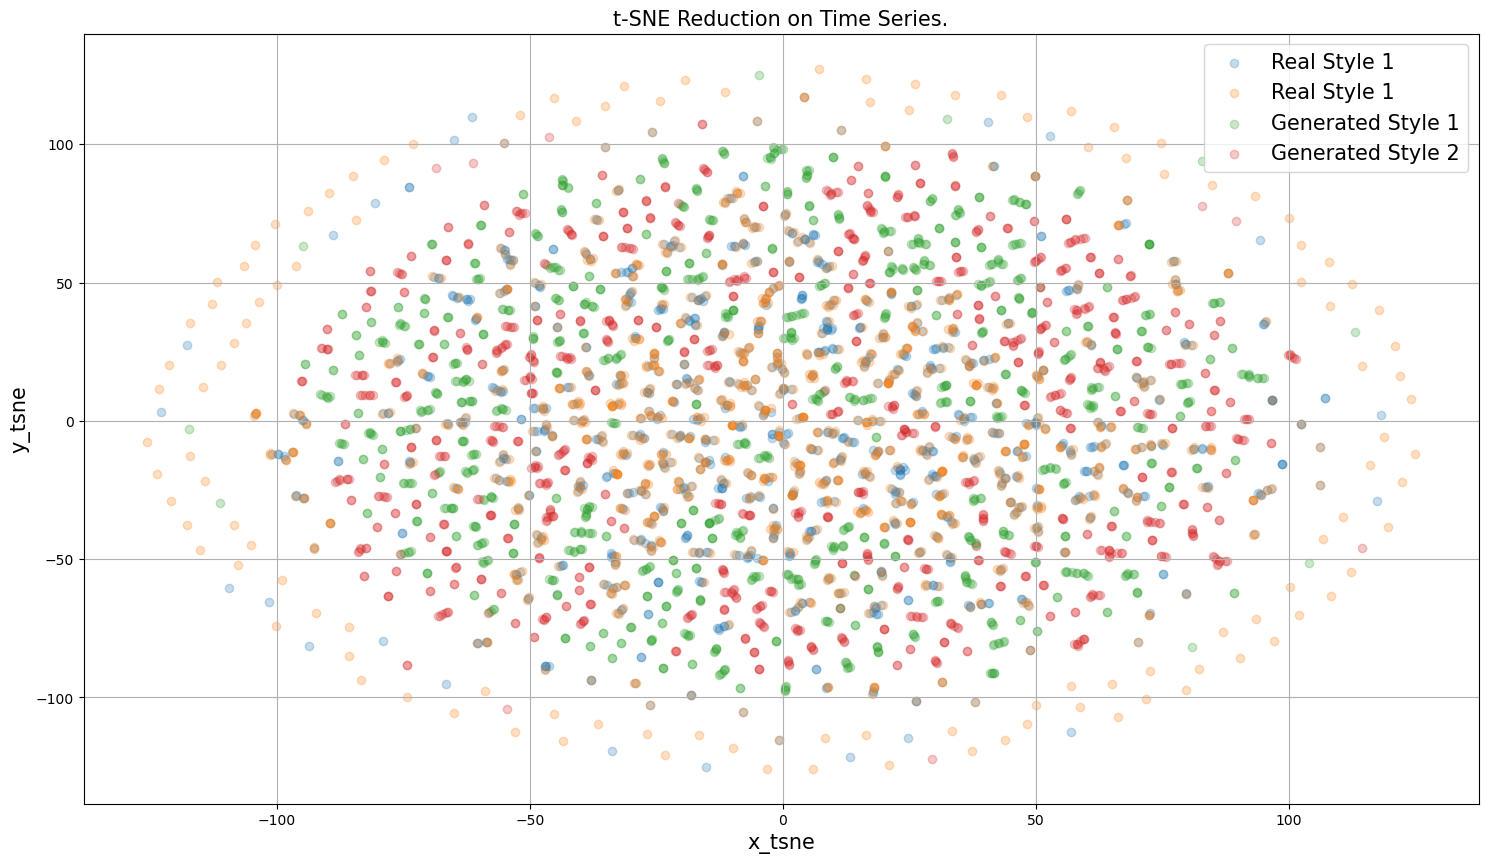

In [ ]:
from sklearn.manifold import TSNE

PLOT_FOLDER = "imgs/Time Series Style Transfer COSCI-GAN"

# seed_content_valid, seed_style1_valid, seed_style2_valid

def make_tsne_vizualisation(content_sequences, style1_sequences, style2_sequences, save_to:str=f"{BASE_DIR}/tsne-reconstruction.pdf"):
    n_sequences= content_sequences.shape[0]
    generated_s1 = generate(content_sequences, style1_sequences)
    generated_s2 = generate(content_sequences, style2_sequences)

    concatenated = tf.concat((style1_sequences, style2_sequences, generated_s1, generated_s2), 0)

    concatenated = tf.reshape(concatenated, (concatenated.shape[0], concatenated.shape[1]* concatenated.shape[2]))

    reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=1 )
    reduced = reducer.fit_transform(concatenated)

    style1_reduced = reduced[:n_sequences]
    style2_reduced = reduced[n_sequences:2*n_sequences]
    generated_s1_reduced = reduced[2*n_sequences:3*n_sequences]
    generated_s2_reduced = reduced[3*n_sequences:]

    plt.figure(figsize=(18, 10))
    plt.scatter(style1_reduced[:, 0], style1_reduced[:, 1], label="Real Style 1", alpha=0.25)
    plt.scatter(style2_reduced[:, 0], style2_reduced[:, 1], label="Real Style 1", alpha=0.25)
    plt.scatter(generated_s1_reduced[:, 0], generated_s1_reduced[:, 1], label="Generated Style 1", alpha=0.25)
    plt.scatter(generated_s2_reduced[:, 0], generated_s2_reduced[:, 1], label="Generated Style 2", alpha=0.25)

    plt.grid()
    plt.title("t-SNE Reduction on Time Series.", fontsize=15)
    plt.ylabel("y_tsne", fontsize=15)
    plt.xlabel("x_tsne", fontsize=15)
    plt.legend(fontsize=15)
    plt.savefig(save_to, bbox_inches='tight')
    plt.show()

make_tsne_vizualisation(seed_content_valid, seed_style1_valid, seed_style2_valid)

### UMAP

In [ ]:
# import umap

# def make_umap_reduction(content_sequences, style1_sequences, style2_sequences, save_to:str=f"{BASE_DIR}/umap-reconstruction.pdf"):
#     n_sequences= content_sequences.shape[0]

#     concatenated = tf.concat((style1_sequences, style2_sequences, content_sequences), 0)

#     concatenated = tf.reshape(concatenated, (concatenated.shape[0], concatenated.shape[1]* concatenated.shape[2]))

#     reducer = umap.UMAP(n_neighbors=150, min_dist=1.)

#     embedding = reducer.fit_transform(concatenated)

#     style1_reduced = embedding[:n_sequences]
#     style2_reduced = embedding[n_sequences:2*n_sequences]
#     generated_s1_reduced = embedding[2*n_sequences:3*n_sequences]

#     plt.figure(figsize=(18, 10))
#     plt.scatter(style1_reduced[:, 0], style1_reduced[:, 1], label="Real Style 1", alpha=0.25)
#     plt.scatter(style2_reduced[:, 0], style2_reduced[:, 1], label="Real Style 1", alpha=0.25)
#     plt.scatter(generated_s1_reduced[:, 0], generated_s1_reduced[:, 1], label="Content Sequences", alpha=0.25)

#     plt.grid()
#     plt.title("UMAP Reduction on Time Series.", fontsize=15)
#     plt.ylabel("y_umap", fontsize=15)
#     plt.xlabel("x_umap", fontsize=15)
#     plt.legend(fontsize=15)
#     plt.savefig(save_to, bbox_inches='tight')
#     plt.show()


# make_umap_reduction(seed_content_valid, seed_style1_valid, seed_style2_valid)
    

In [ ]:
import umap

def make_umap_reduction(content_sequences, style1_sequences, style2_sequences, save_to:str=f"{BASE_DIR}/umap-reconstruction.pdf"):
    n_sequences= content_sequences.shape[0]
    generated_s1 = generate(content_sequences, style1_sequences)
    generated_s2 = generate(content_sequences, style2_sequences)

    concatenated = tf.concat((style1_sequences, style2_sequences, generated_s1, generated_s2), 0)

    concatenated = tf.reshape(concatenated, (concatenated.shape[0], concatenated.shape[1]* concatenated.shape[2]))

    reducer = umap.UMAP(n_neighbors=150, min_dist=1.)

    embedding = reducer.fit_transform(concatenated)

    style1_reduced = embedding[:n_sequences]
    style2_reduced = embedding[n_sequences:2*n_sequences]
    generated_s1_reduced = embedding[2*n_sequences:3*n_sequences]
    generated_s2_reduced = embedding[3*n_sequences:]

    plt.figure(figsize=(18, 10))
    plt.scatter(style1_reduced[:, 0], style1_reduced[:, 1], label="Real Style 1", alpha=0.25)
    plt.scatter(style2_reduced[:, 0], style2_reduced[:, 1], label="Real Style 1", alpha=0.25)
    plt.scatter(generated_s1_reduced[:, 0], generated_s1_reduced[:, 1], label="Generated Style 1", alpha=0.25)
    plt.scatter(generated_s2_reduced[:, 0], generated_s2_reduced[:, 1], label="Generated Style 2", alpha=0.25)

    plt.grid()
    plt.title("UMAP Reduction on Time Series.", fontsize=15)
    plt.ylabel("y_umap", fontsize=15)
    plt.xlabel("x_umap", fontsize=15)
    plt.legend(fontsize=15)
    plt.savefig(save_to, bbox_inches='tight')
    plt.show()


make_umap_reduction(seed_content_valid, seed_style1_valid, seed_style2_valid)
    

ModuleNotFoundError: No module named 'umap'

### TSTR Method

In [ ]:
from models.NaiveClassifier import make_naive_discriminator

def extract_labels(dset:tf.data.Dataset):
    return dset.map(lambda s: (s[:, :, :-1], s[:, int(SEQUENCE_LENGTH//2), -1]))


def stylize_dataset(content_dataset:tf.data.Dataset, style_dataset:tf.data.Dataset):
    mixted_dataset = tf.data.Dataset.zip((content_dataset, style_dataset))
    stylized_dataset = mixted_dataset.map(lambda _cont, _sty: (generate(_cont[0], _sty[0]), _cont[1]))
    return stylized_dataset


def train_naive_classifier(train_classif_dataset:tf.data.Dataset, valid_classif_dataset:tf.data.Dataset)->tf.keras.models.Model:
    naive_model = make_naive_discriminator((SEQUENCE_LENGTH, N_SIGNAL), 5)
    _epochs = 10
    
    history = naive_model.fit(train_classif_dataset, validation_data=valid_classif_dataset, epochs=_epochs)

    return naive_model, history

def tstr_test(style_label:int):
    # In this test, we will 
    # Train a naive classifier on the stylized dataset by the network.
    # Test this naive model on the real stylized dataset.

        
    dset_content_train, dset_content_valid = loading_wrapper(CONTENT_DATASET_PATH, SEQUENCE_LENGTH, GRANUARITY, OVERLAP, BS, drop_labels=False)
    dset_style_train, dset_style_valid = loading_wrapper(STYLE_DATASET_PATHS[style_label], SEQUENCE_LENGTH, GRANUARITY, OVERLAP, BS, drop_labels=False)

    _content_dset_train = extract_labels(dset_content_train)
    _content_dset_valid = extract_labels(dset_content_valid)

    _style_dset_train = extract_labels(dset_style_train)
    _style_dset_valid = extract_labels(dset_style_valid)

    # Generate the 'stylized' dataset 
    _generated_train = stylize_dataset(_content_dset_train, _style_dset_train)
    _generated_valid = stylize_dataset(_content_dset_valid, _style_dset_valid)

    # Train a classifier on the stylized dataset.
    print("[+] Train on Generated Data.")
    naive_12_model, naive_on_generated_hist = train_naive_classifier(_generated_train, _generated_valid)
    # Evaluate on generated
    naive_gen_trained_on_gen = naive_12_model.evaluate(_generated_valid)[1]
    naive_gen_trained_on_real = naive_12_model.evaluate(_content_dset_valid)[1]


    # Train on the real Dataset.
    print("[+] Train on Real Data.")
    naive_on_real, naive_on_real_hist = train_naive_classifier(_content_dset_train, _content_dset_valid)
    eval_on_real = naive_on_real.evaluate(_content_dset_valid)[1]
    eval_on_generated= naive_on_real.evaluate(_generated_valid)[1]


    print("fTrained on Generated dataset. (Style Label {style_label})")
    print(f"[+] Acc on Generated valid set: {naive_gen_trained_on_gen:0.2f}.")
    print(f"[+] Acc on Real valid set:      {naive_gen_trained_on_real:0.2f}.")

    print(f"Trained on Real dataset. (Style Label {style_label})")
    print(f"[+] Acc on Generated valid set: {eval_on_generated:0.2f}.")
    print(f"[+] Acc on Real valid set:      {eval_on_real:0.2f}.")

    print('[+] Show Histories.')

    plt.figure(figsize=(18, 5))
    ax = plt.subplot(111)
    ax.grid(True)
    ax.set_title('Loss durring the training on *real* data.')
    plt.plot(naive_on_real_hist.history['loss'], ".-", label="Train Loss.")
    plt.plot(naive_on_real_hist.history['val_loss'], ".-", label="Valid Loss.")
    plt.legend()
    plt.show()


    plt.figure(figsize=(18, 5))
    ax = plt.subplot(111)
    ax.grid(True)
    ax.set_title(f'Loss durring the training on *generated* data. (Style Label {style_label})')
    plt.plot(naive_on_generated_hist.history['loss'], ".-", label="Train Loss.")
    plt.plot(naive_on_generated_hist.history['val_loss'], ".-", label="Valid Loss.")
    plt.legend()

    plt.show()

    cols = ["Style Label", "Naive trained on Gen, Gen Acc", "Naive trained on Gen, Real Acc", "Naive trained on Real, Gen Acc", "Naive trained on Real, Real Acc"]
    df = pd.DataFrame([[style_label, naive_gen_trained_on_gen, naive_gen_trained_on_real, eval_on_real, eval_on_generated]], columns=cols)

    return df

In [ ]:
style_0_results = tstr_test(0)

64 16 1
64 16 1
64 16 1
64 16 1
[+] Train on Generated Data.
Epoch 1/10
   1389/Unknown - 7s 4ms/step - loss: 1.5024 - sparse_categorical_accuracy: 0.3053

KeyboardInterrupt: 

## Log Results

64 16 1
64 16 1
64 16 1
64 16 1
[+] Train on Generated Data.
Epoch 1/10
2499/2499 [==============================] - 15s 6ms/step - loss: 1.4472 - sparse_categorical_accuracy: 0.3337 - val_loss: 1.3016 - val_sparse_categorical_accuracy: 0.3902
Epoch 2/10
2499/2499 [==============================] - 14s 6ms/step - loss: 1.3130 - sparse_categorical_accuracy: 0.3856 - val_loss: 1.2910 - val_sparse_categorical_accuracy: 0.3909
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 1.2991 - sparse_categorical_accuracy: 0.3882 - val_loss: 1.3005 - val_sparse_categorical_accuracy: 0.3928
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 1.2931 - sparse_categorical_accuracy: 0.3927 - val_loss: 1.2836 - val_sparse_categorical_accuracy: 0.3975
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 1.2890 - sparse_categorical_accuracy: 0.3920 - val_loss: 1.2806 - val_sparse_categorical_accuracy: 0.3978
Epoch 6/10
2499/2499 [==

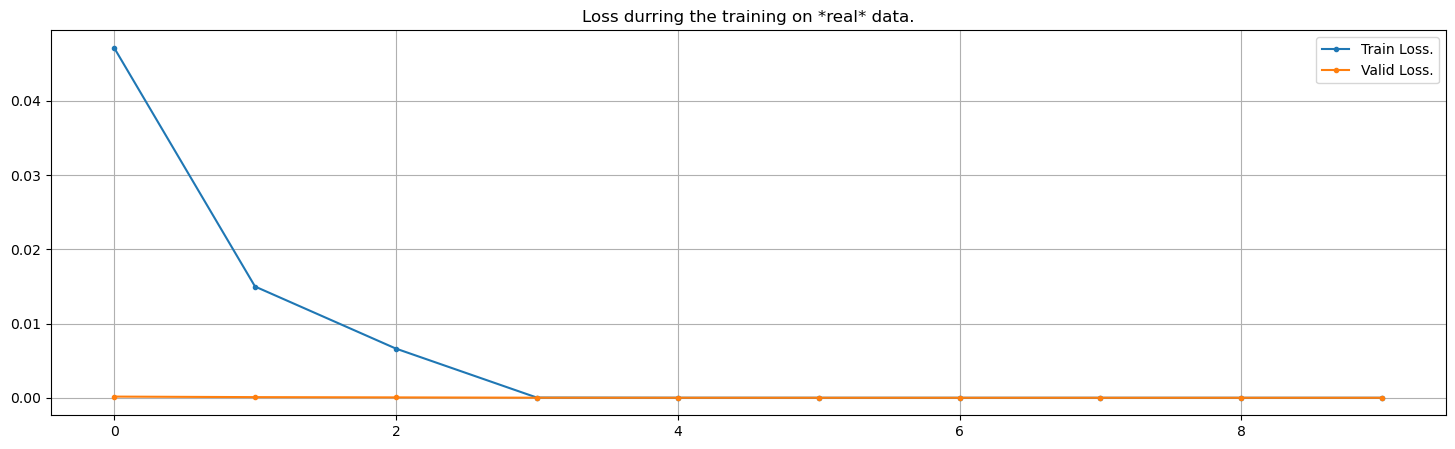

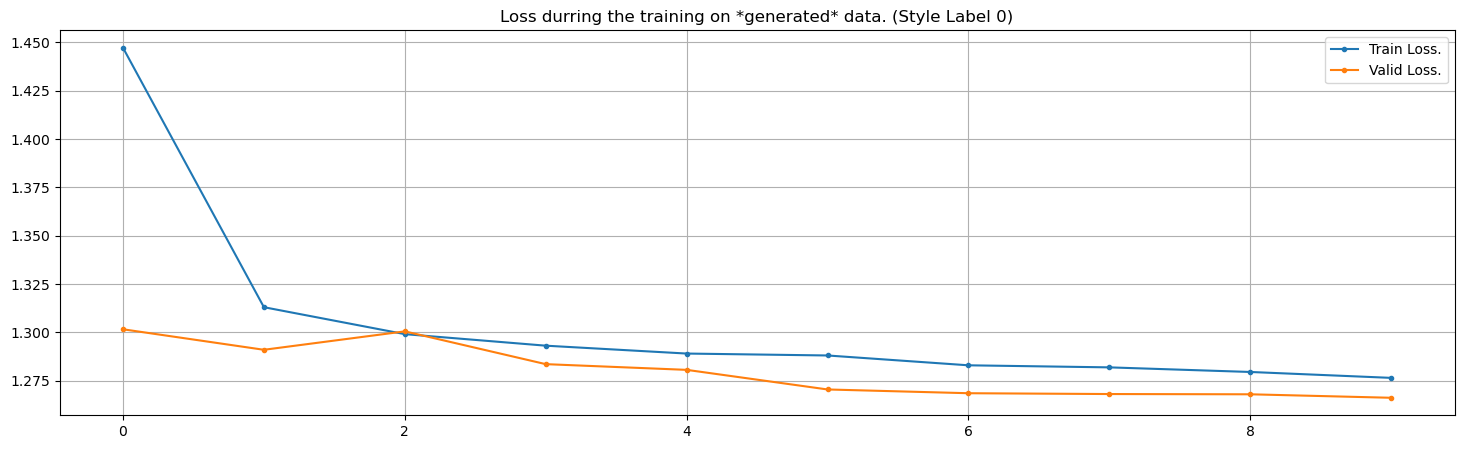

64 16 1
64 16 1
64 16 1
64 16 1
[+] Train on Generated Data.
Epoch 1/10
2499/2499 [==============================] - 15s 6ms/step - loss: 1.4850 - sparse_categorical_accuracy: 0.3139 - val_loss: 1.3809 - val_sparse_categorical_accuracy: 0.3852
Epoch 2/10
2499/2499 [==============================] - 14s 6ms/step - loss: 1.3267 - sparse_categorical_accuracy: 0.3818 - val_loss: 1.3050 - val_sparse_categorical_accuracy: 0.3792
Epoch 3/10
2499/2499 [==============================] - 14s 6ms/step - loss: 1.3019 - sparse_categorical_accuracy: 0.3841 - val_loss: 1.2830 - val_sparse_categorical_accuracy: 0.3915
Epoch 4/10
2499/2499 [==============================] - 14s 6ms/step - loss: 1.2972 - sparse_categorical_accuracy: 0.3848 - val_loss: 1.2828 - val_sparse_categorical_accuracy: 0.3901
Epoch 5/10
2499/2499 [==============================] - 14s 6ms/step - loss: 1.2939 - sparse_categorical_accuracy: 0.3852 - val_loss: 1.2749 - val_sparse_categorical_accuracy: 0.3933
Epoch 6/10
2499/2499 [==

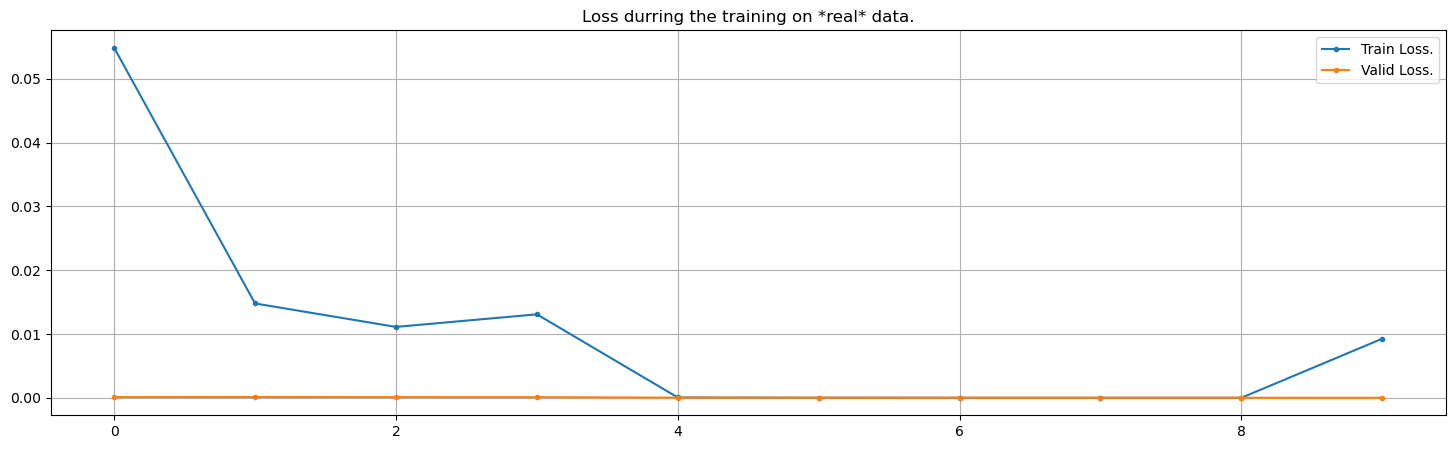

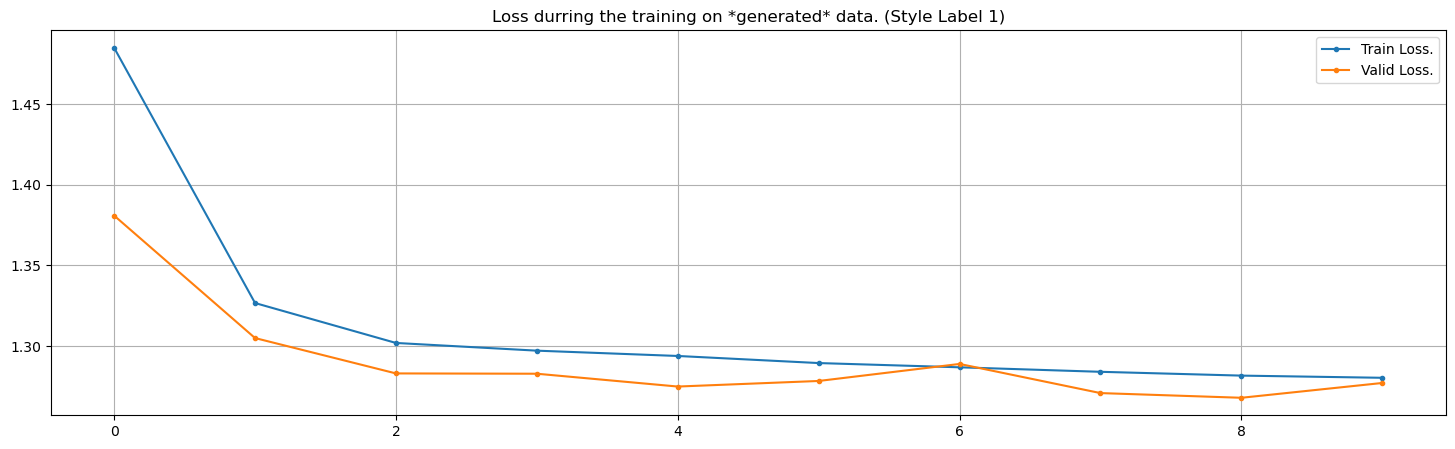

ModuleNotFoundError: No module named 'openpyxl'

In [ ]:
def log_results(folder_to_save:str):
    # Create the folder.
    file_path = f"{folder_to_save}/scores.xlsx"

    style_0_results = tstr_test(0)
    style_1_results = tstr_test(1)

    full_df = pd.concat((style_0_results, style_1_results), ignore_index=True)
    full_df = full_df.set_index(['Style Label'])

    full_df.to_excel(file_path)

log_results(SAVE_FOLDER)